---
title: "Treeifying Graphs: Tree Decomposition"
date: 2025-02-03
---

Trees are good. For many questions you can process them from leaves to parents. If you remove a vertex, it will cut the tree apart. Communication can only happen through a single path.

There are quite a number of decompositions of graphs. The very word decomposition suggests that you are probably breaking the graph apart into simpler pieces. Maybe this breaking apart in in some sense recursive or inductive leading to a divide and conquer approach to dealing with the graph. Many of these decompositions are about describing a method to construct the graph by combining simpler pieces.

- https://en.wikipedia.org/wiki/Tree_decomposition
- https://en.wikipedia.org/wiki/Pathwidth
- https://en.wikipedia.org/wiki/Modular_decomposition
- https://en.wikipedia.org/wiki/Branch-decomposition
- https://en.wikipedia.org/wiki/Graph_partition

A blog post I want to write but can't figure out how to is on the general phenomenon of trying to "treeify graphs". This is the game we seem to play trying to model graphical topics in egraphs, which only comfortably handle pure trees. An intuition I've been following is whether there is a way to bake in something like a dynamic tree decomposition into an egraph data structure. I don't have anything concrete though.

Tree decompositions are one example of this treeifying graph phenomenon. But there are others

- Regular expressions and DFAs. Regular expressions are trees. Automata are graphy (although with an odd notion of homomorphism or equality. Often only observable behavior is relevant). They are interconvertible, but regexes may be treatable in simple compositional ways See Tarjan paper https://dl.acm.org/doi/10.5555/892083 Solving path problems on directed graphs.
- Structured languages and CFGs. [Relooper](https://dl.acm.org/doi/10.1145/3547621) turns cfgs into sttuctured control flow which are syntax trees. MLIR and RVSDG try to make the control flow graph even more structured and tree like in some respects.
- Algebraic Graphs. [Mokhov](https://dl.acm.org/doi/10.1145/3122955.3122956), Schrijver, Kidney.
- Tree Decomposition. Metis. Domain Decomposition,
- String diagrams and categorical combinators. This is perhaps related to [Series parallel decomposition](https://en.wikipedia.org/wiki/Series%E2%80%93parallel_graph) as monoidal categories have a horizontal (parallel) and vertical composition (series). This particular trick is kind of what brought me into egraphs https://www.philipzucker.com/rust-category/
- Algebra of Programming. Backhouse.
- Lambda term technology. De bruijn indices, named reprs. Names are the analog of vertex labels in graphs, a kludge. Lambdas muddy the water about whether they are really "terms" because the variables make them more entangled than a nice simple tree. You can embed lambdas as graphs by having variables backedge point to their binding sites and lambda normalization as graph rewriting.

Different communities have very different perspectives here. The graph theory / Theory of computation people seem to prefer the tree decomposition style stuff of often undirected unrooted graphs where vertices do not have ports/ordered children. Programming language people seems to prefer things that are more AST like, with roots and ported vertices / ordered children.  I would like to understand how these perspectives could be fused or played off each other.

Graphs come in a number of flavors. The word graph does not mean one thing. It is dependent on the community you are talking to
- multigraphs can have more than one edge between the same two nodes
- labels on the edges and/or vertices or not
- Labelled and/or ordered ports on the vertices or not. Input vs output ports.
- Single output port or many.
- DAG, tree, or graph.
- Rooted or not.
- Directed vs undirected

I dunno. If you've got something to say, DM me or email me. It's an interesting set of topics.

## Tree Decomposition

The tree decomposition is in particular interesting because it gives a knob of sorts to dial between trees and more general graphs. A good tree decomposition can be useful to solve certain graph problems fast via dynamic programming and tree decomposition has some relationship to good elimination orderings (elimination being a process to fuse together vertices one by one).

First let's look at a simple tree decomposition of a path graph.


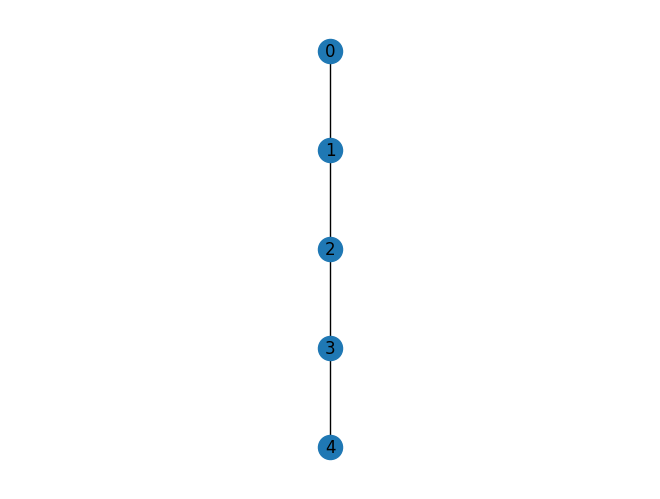

In [11]:
import networkx as nx
def mydraw(G):
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Requires pygraphviz
    nx.draw(G, pos, with_labels=True)

G = nx.path_graph(5)
mydraw(G)

The function `treewidth_min_degree` is a heuristic algorithm to find a decent tree decomposition. The number quoted is not necesdsarily the actually treewdith (which is the size of the smallest bag - 1 of the tree decomposition with the smallest)

treewidth 1


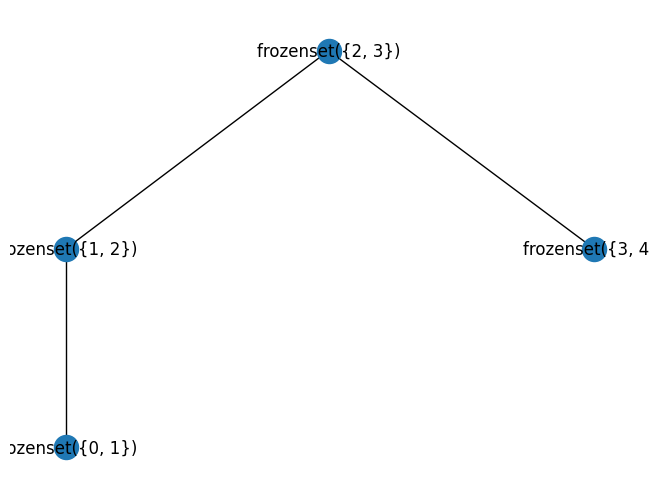

In [99]:
w, TD = nx.approximation.treewidth_min_degree(G)
print("treewidth", w)
mydraw(TD)

A very untree-like graph is the complete graph

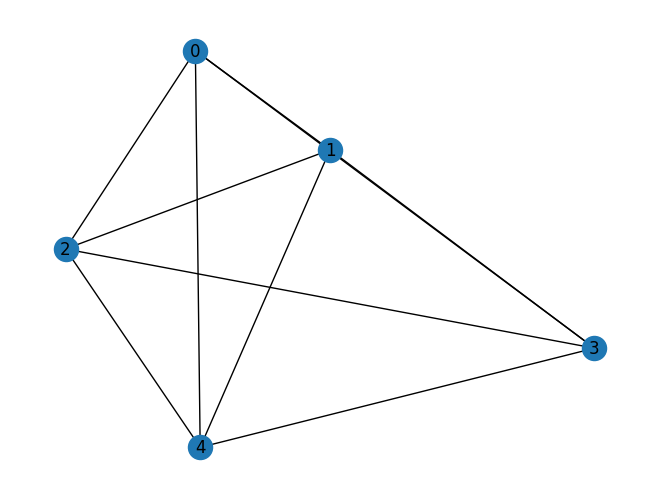

In [100]:
G = nx.complete_graph(5)
mydraw(G)

The tree decomposition can't do anything with this, giving a tree decomposition with a single huge bag (always a valid answer according to the definition of tree decomposition, but not a useful one.)

treewidth 4


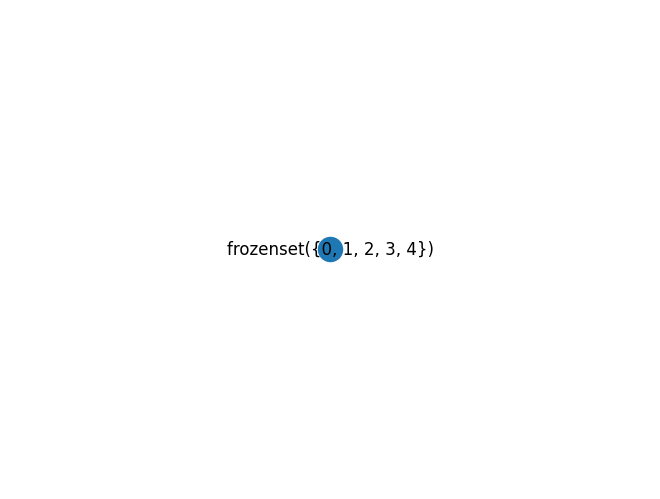

In [101]:
w, TD = nx.approximation.treewidth_min_degree(G)
print("treewidth", w)
mydraw(TD)

Another interesting graph is a loop

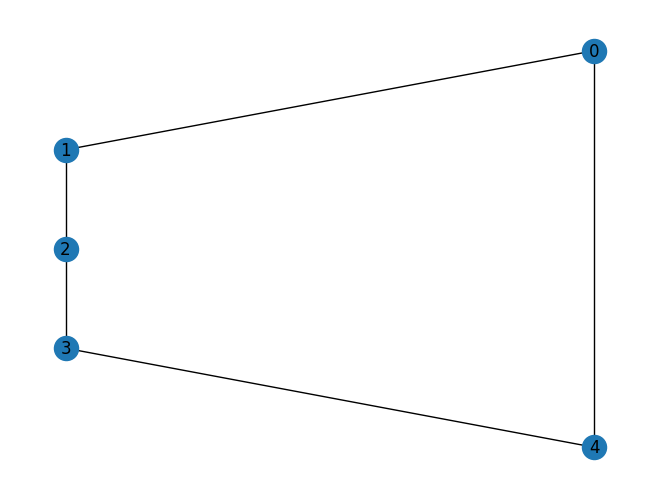

In [102]:
G = nx.cycle_graph(5)
mydraw(G)

The tree decomposition here always has `4` in play. Note that the middle node of the decomposition has a `4` even though, `1` and `2` have no edge to `4`.
The treewidth of 2 shows that a cycle is almost tree-like. It's not so bad.

treewidth 2


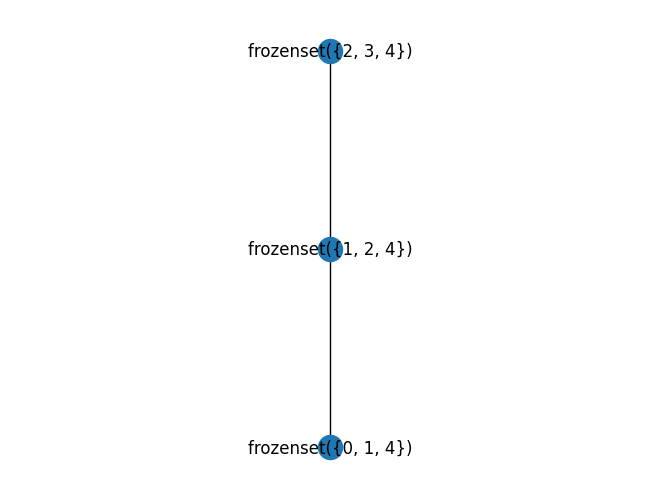

In [103]:
w, TD = nx.approximation.treewidth_min_degree(G)
print("treewidth", w)
mydraw(TD)

# Reifying Tree Decomposition into an AST

An interesting thing to do is actually reify this tree decomposition as a tree-like data structure for storing graphs.

Under the hood networkx graphs are neighbor dictionaries. But we could also represent graphs usefully as an adjacency list of tuples. This is yet another representation. It just has a hierarchical structure to the adjacency lists.

TreeDecomp(nodes=frozenset({1, 2, 4}),
           edges={(1, 2), (2, 1)},
           children=[TreeDecomp(nodes=frozenset({2, 3, 4}),
                                edges={(2, 3), (3, 2), (3, 4), (4, 3)},
                                children=[]),
                     TreeDecomp(nodes=frozenset({0, 1, 4}),
                                edges={(0, 1), (1, 0), (4, 0), (0, 4)},
                                children=[])])


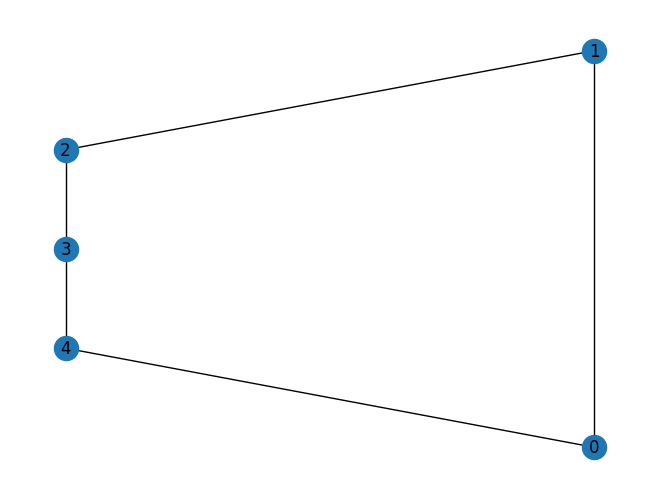

In [12]:
from dataclasses import dataclass

@dataclass
class TreeDecomp():
    nodes: set[object]
    edges : set[tuple[object, object]]
    children : list["TreeDecomp"]

    def to_graph(self):
        G = nx.Graph()
        def worker(td):
            for i,j in td.edges:
                G.add_edge(i,j)
            for child in td.children:
                worker(child)
        worker(self)
        return G


def tree_decomp(G) -> TreeDecomp:
    w, G1 = nx.approximation.treewidth_min_degree(G)
    center_nodes = nx.center(G1)
    central_vertex = center_nodes[0]
    seen = set()
    def dfs(v):
        seen.add(v)
        children = [dfs(child) for child in G1.neighbors(v) if child not in seen]
        return TreeDecomp(nodes=v, edges=set((i,j) for i in v for j in v if (i,j) in G.edges), children=children)
    return dfs(central_vertex)

import pprint
pprint.pprint(tree_decomp(nx.cycle_graph(5)))
mydraw(tree_decomp(nx.cycle_graph(5)).to_graph())

## Partitions

There is some similarity and interconnection between tree decompositions and graph partitioning.

Graph partitioning software like [METIS](https://github.com/KarypisLab/METIS) is used to break up meshes into smaller pieces and to derive a useful variable ordering to minimize fill in in linear algebra applications.

https://networkx.org/documentation/stable/reference/algorithms/community.html networkx also has a number of partitioning algorithms


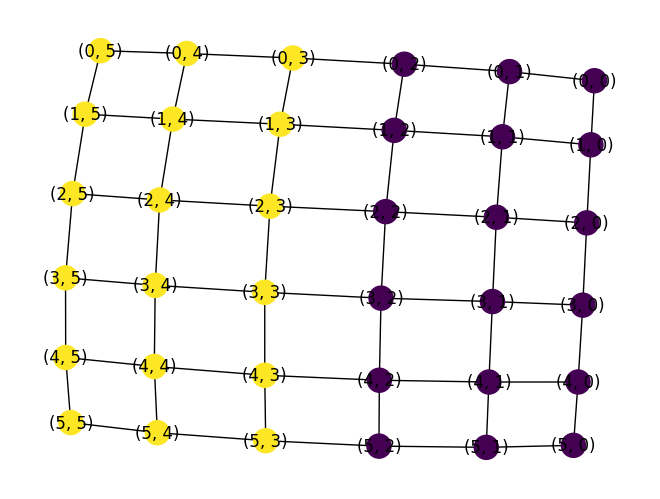

In [5]:
import networkx as nx
import metis
G = nx.grid_2d_graph(6, 6)
(edgecuts, parts) = metis.part_graph(G, 2)
edgecuts
parts
nx.draw(G, node_color=parts, with_labels=True)

One can reify a recursive partition into a tree also.

This paper
["Correspondence between Multilevel Graph Partitions and Tree Decompositions"](https://www.mdpi.com/1999-4893/12/9/198 ) claims that basically you can derive a tree decomposition from such a partition. It won't necessarily be a good one. Here we can see that it has a bigger than necessary tree width.


In [8]:
from dataclasses import dataclass

@dataclass
class MultiLevel():
    nodes : set[object] # nodes is implicit in the other data.
    edges: set[tuple[object, object]]
    subs: list["MultiLevel"]

    def to_graph(self):
        G = nx.Graph()
        def worker(ml):
            for i,j in ml.edges:
                G.add_edge(i,j)
            for sub in ml.subs:
                worker(sub)
        worker(self)
        return G
    
    def to_tree_decomp(self):
        return TreeDecomp(nodes={v for ij in self.edges for v in ij}, edges=self.edges, children=[sub.to_tree_decomp() for sub in self.subs])

def multilevel(G):
    if len(G) == 1:
        return MultiLevel(nodes=set(G.nodes), edges=set(), subs=[])
    else:
        p1,p2 = nx.community.kernighan_lin_bisection(G)
        G1 = G.subgraph(p1)
        G2 = G.subgraph(p2)
        edges = {(i,j) for i,j in G.edges if (i in p1 and j in p2) or (i in p2 and j in p1)}
        return MultiLevel(nodes=set(G.nodes), edges=edges, subs=[multilevel(G1), multilevel(G2)])

import pprint
ml = multilevel(nx.cycle_graph(5))
pprint.pprint(ml)

MultiLevel(nodes={0, 1, 2, 3, 4},
           edges={(2, 3), (0, 4)},
           subs=[MultiLevel(nodes={3, 4},
                            edges={(3, 4)},
                            subs=[MultiLevel(nodes={3}, edges=set(), subs=[]),
                                  MultiLevel(nodes={4}, edges=set(), subs=[])]),
                 MultiLevel(nodes={0, 1, 2},
                            edges={(1, 2)},
                            subs=[MultiLevel(nodes={2}, edges=set(), subs=[]),
                                  MultiLevel(nodes={0, 1},
                                             edges={(0, 1)},
                                             subs=[MultiLevel(nodes={1},
                                                              edges=set(),
                                                              subs=[]),
                                                   MultiLevel(nodes={0},
                                                              edges=set(),
                             

In [13]:
pprint.pprint(ml.to_tree_decomp()) # This is a bad tree decomposition, but I think it is one. We could do a split and rebalnce move maybe to improve it.``

TreeDecomp(nodes={0, 2, 3, 4},
           edges={(2, 3), (0, 4)},
           children=[TreeDecomp(nodes={3, 4},
                                edges={(3, 4)},
                                children=[TreeDecomp(nodes=set(),
                                                     edges=set(),
                                                     children=[]),
                                          TreeDecomp(nodes=set(),
                                                     edges=set(),
                                                     children=[])]),
                     TreeDecomp(nodes={1, 2},
                                edges={(1, 2)},
                                children=[TreeDecomp(nodes=set(),
                                                     edges=set(),
                                                     children=[]),
                                          TreeDecomp(nodes={0, 1},
                                                     edges={(0, 1)},
           

# Bits and Bobbles

Algebraic graphs doesn't seem that different from the perspective of graph decompositions. They are a tree describing a way of constructing the graph out of operations. These operations may have nice algerbaic properties with respect to each other, like distributivity.

- https://www.cs.tufts.edu/comp/150FP/archive/andrey-mokhov/algebraic-graphs.pdf Algebraic Graphs with Class (Functional Pearl). 
- https://arxiv.org/abs/2202.09230 United Monoids: Finding Simplicial Sets and Labelled Algebraic Graphs in Trees
- https://arxiv.org/abs/2403.02273 Let a Thousand Flowers Bloom: An Algebraic Representation for Edge Graphs
- https://dl.acm.org/doi/abs/10.1145/3704892  Formalising Graph Algorithms with Coinduction
- https://dl.acm.org/doi/10.1145/3473577  Algebras for weighted search
- https://dl.acm.org/doi/10.1145/2500365.2500613 Fun with semirings: a functional pearl on the abuse of linear algebra


Trees are nice. You can often treat the leaves and then treat the parents of those leaves until you finish processing the whole graph. Many analyses or computations on trees are compositional in this sense. You can solve them by top down recursion, or single pass bottom up iteration.

Trees are also nice similarly because we can sometimes semantically interpret them compositionally (as a simple recursive functional program of type `Tree -> Meaning` ). Like the syntax tree `add(one,two)` is easy top interpret as the natural number `3` via a function `eval : aexpr -> nat`.

Graph rewriting is less straightforward (not impossibly so, but less) that term rewriting. It can be implemented mutationally, and it has a large body of theory, but still is a higher shelf to reach for than term rewriting.

Graphical structures come up very naturally when discussing lambdas a program representations. Alpha invariant names are often an indirection describing some kind of loopy connectivity.

For terms, we have a nice raft of data structures to work with. Algebraic datatypes, Hash conses and egraphs.

What I've begun to see as a general theme is that we try various scams to try and treeify graphs. I suspect a way forward is to bake some of these ideas into egraphs.

There is almost certainly not one graph decomposition to rule them all here. This feels similar to me to the idea of a view https://www.cs.tufts.edu/~nr/cs257/archive/phil-wadler/views.pdf in functional programming or in databases. Sometimes different tree-like views are useful.

It is also probably not possible or desirable to get unique or canonical or minimal decompositions. Heuristics can get you a very nice decomposition for cheap, but actually finding a best one is usually going to be NP-complete.

There are often local moves / equational reasoning for manipulating these treeified graphs. These local moves can greedily relax a suboptimal decomposition into a better one.
 

It is a curious phenomenon that low level languages like C and C++ make pointery graphs just as natural and easy as trees in some respects. The pure functional languages make this a harder thing to reach for. Rust makes this annoying via ownership. It is not insurmountable, you just need to build your own "address space" using an arena vector or map data structure. Still, this is one small step.


It is less straightforward to me the method to semantically interpret graphs. The graph probably needs to represent a system of constraints that needs to be solved in some way. We do have nice methods to semantically interpret lambda terms and some other things that are more graphy in nature. Non-wellfounded sets have nations like this (see vicious circles or aczel's book)


Considering the edges as a relation `edge(v1,v2)`, the relation is [well founded](https://en.wikipedia.org/wiki/Well-founded_relation) for finite acyclic graphs. I would claim that well founded is just a mathematical rigorization of our intuitions of tree-like relations.


What graph theorists or networkx mean by trees is not really quite the same thing I (or compiler / PL people) mean by trees. The trees i like the best are AST-like or algebraic datatype like. They are rooted and have an ordering of the children of each node.




https://github.com/pa-ba/calc-graph-comp  Beyond Trees: Calculating Graph-Based Compilers. This uses HOAS lambdas to model graphs. The opposite direction from what I was pointing out.



## More on tree decompositions

Tree decomposition is useful for dynamic programming combinatorial problems on graphs. The bag of vertices in the node is sort of the open interface. You can solve the subproblems parametrized on
 the values that the problem takes on at the interface.

Tree decompositions are also used in query optimization https://pages.cs.wisc.edu/~paris/cs784-s19/lectures/lecture5.pdf You can represent a databse query as a graph or hypergraph (hypergraphs are embeddable into graphs by making hyperedge nodes and turning the graph bipartite between hyperedge nodes and vertices).

Each hyperedge represents a relation and the vertices it connects to are the joining columns. You want to keep the working set small of intermeidate results. This corresponds to the bags in the hypertree deocmposition.

A databasee query is kind of a "proof relevant" form of counting solutions. We already know graph coloring is embeddable into a query if we put the complicated graph structure in thuery itself. https://www.philipzucker.com/sql_graph_csp/

The networkx algorithm performs elimination of veices (connecting neighbors when vertex is eliminated) and then uses that information to build a tree decomposition. https://networkx.org/documentation/stable/_modules/networkx/algorithms/approximation/treewidth.html#treewidth_min_degree

https://www.mdpi.com/1999-4893/12/9/198 Correspondence between Multilevel Graph Partitions and Tree Decompositions
TH
THe tree decomposition is like a sliding window moving over the graph where the window can't have a vertex disappear asnd then reappear. The window has ast least one edge in it.

https://www.youtube.com/watch?v=gCZrasaG0vA

In [ ]:
def treewidth(G):
    vertices = list(G.nodes)
    while vertices:
        v.pop()
        


In [ ]:
import itertools
def color(N, constr , td : TreeDecomp):
    vs = list(td.nodes)
    for coloring in itertools.product(range(N), repeat=len(vs)):
        zip(vs,coloring)
        for i,j in td.edges:
            if constr(i,j):
                if coloring[i] == coloring[j]:
                    break
        pass
    td.nodes

def ncolor(N, td : TreeDecomp):
    subprobs = [ncolor(child) for child in td.children]
    vs = list(td.nodes)
    acc = {}
    for coloring in itertools.product(range(N), repeat=len(vs)):
        coloring = {i:c for i,c in zip(vs,coloring)}
        if any(coloring[i] == coloring[j] for i,j in td.edges): # bad coloring
            break
        macc = 1
        for subprob in subprobs:

        pass

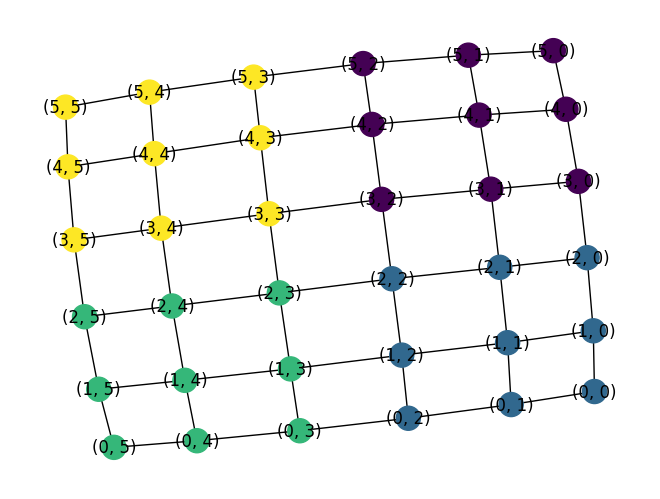

In [132]:
import networkx as nx
import metis
#G = metis.example_networkx()
G = nx.grid_2d_graph(6, 6)
(edgecuts, parts) = metis.part_graph(G, 4)
edgecuts
parts
nx.draw(G, node_color=parts, with_labels=True)


In [135]:
G = nx.cycle_graph(5)
nx.community.kernighan_lin_bisection(G)

({0, 1}, {2, 3, 4})

---
title: Treeifying Graphs
date: 2025-02-03
---








# Bits and Bobbles




## Regular Expressions


## String Diagrams and Series-Parallel Decomposition
https://en.wikipedia.org/wiki/Series%E2%80%93parallel_graph

In [ ]:
class Series(NT):
    s : object
    t : object

In [93]:
import passagemath.graphs as graphs
G = Graph(Integer(2))
for i in range(Integer(3)):
     G.add_clique([Integer(0), Integer(1), G.add_vertex(), G.add_vertex()])
tric = TriconnectivitySPQR(G)

ModuleNotFoundError: No module named 'passagemath'

## Lambda Terms

Hash consings modulo alpha
nominal techniques


## Algebraic Graphs
Algebraic graphs doesn't seem that different from the perspective of graph decompositions. They are a tree describing a way of constructing the graph out of operations. These operations may have nice algerbaic properties with respect to each other, like distributivity.

- https://www.cs.tufts.edu/comp/150FP/archive/andrey-mokhov/algebraic-graphs.pdf Algebraic Graphs with Class (Functional Pearl). 
- https://arxiv.org/abs/2202.09230 United Monoids: Finding Simplicial Sets and Labelled Algebraic Graphs in Trees
- https://arxiv.org/abs/2403.02273 Let a Thousand Flowers Bloom: An Algebraic Representation for Edge Graphs
- https://dl.acm.org/doi/abs/10.1145/3704892  Formalising Graph Algorithms with Coinduction
- https://dl.acm.org/doi/10.1145/3473577  Algebras for weighted search
- https://dl.acm.org/doi/10.1145/2500365.2500613 Fun with semirings: a functional pearl on the abuse of linear algebra

In [ ]:
from typing import NamedTuple
NT = NamedTuple
class Graph(NamedTuple):
    def __add__(self, other):
        pass
class Empty(Graph): pass
class Vertex(Graph): vert: object
class OverLay(Graph): g1: Graph; g2: Graph
class Conntect(Graph): g1: Graph; g2: Graph


def eval_graph(g : Graph) -> nx.Graph:
    match g:
        case Empty():
            return nx.Graph()
        case Vertex(vert):
            return nx.Graph()



## CFGs
Beyond Relooper: recursive translation of unstructured control flow to structured control flow (functional pearl) https://dl.acm.org/doi/10.1145/3547621 https://www.youtube.com/watch?v=qAeEWKr9wfU&ab_channel=ACMSIGPLAN
Peterson Kasam Tokura
https://toot.cat/@jamey/110399070056263970  https://dl.acm.org/doi/10.1145/2693261 Perfect Reconstructability of Control Flow from Demand Dependence Graphs

https://networkx.org/documentation/stable/reference/algorithms/dominance.html

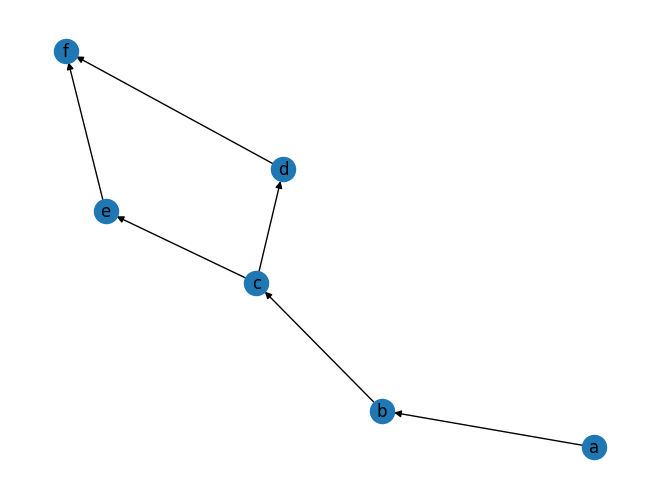

In [38]:
from networkx.algorithms.dominance import immediate_dominators

a,b,c,d,e,f = "a b c d e f".split()
#G = nx.DiGraph([(1, 2), (2, 3), (3, 4), (3, 5), (4, 6), (5, 6)])
G = nx.DiGraph([(a, b), (b, c), (c, d), (c, e), (d, f), (e, f)])
nx.draw(G, with_labels=True)


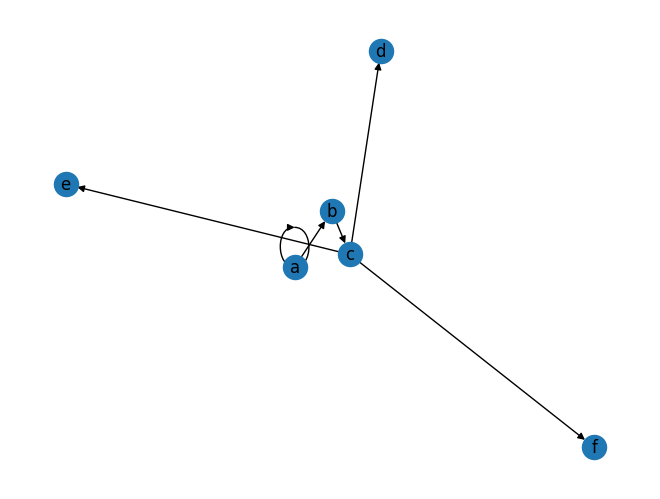

In [40]:
idom = immediate_dominators(G,a)
G1 = nx.DiGraph([(i,j) for j,i in idom.items()])
nx.draw(G1, with_labels=True)

In [42]:
#nx.dfs_postorder_nodes(G, source=1)

def treeify(G):
    seen = {}
    backedge = []
    def worker(i):
        return  (i, [worker(child) for child in G.neighbors(i) if child != i])
    return worker(a)
treeify(G1)

('a', [('b', [('c', [('e', []), ('d', []), ('f', [])])])])

In [54]:
postorder = {v : i for i, v in  enumerate(nx.dfs_postorder_nodes(G, source=a))}
def is_back(v1,v2):
    if postorder[v1] > postorder[v2]:
        return False
    else:
        return True

assert not is_back(a,b)
assert is_back(f,a)


In [52]:
def is_merge(v):
    return len(list(G.predecessors(v))) > 1

is_merge(c)

False

In [55]:
def is_loop(v):
    return any(is_back(v1,v) for v1 in G.predecessors(v))

assert all(not is_loop(v) for v in "abcdef")


In [ ]:
class Break(NT): ind: int
class Block(NT): body: list[object]
class If(NT): cond: object; then: object; els: object
class Loop(NT): body: list[object]



In [ ]:
def doTree(x):
    (node, children) = x
    if len(children) == 1:
        


## Metis

## Tree Decomposition


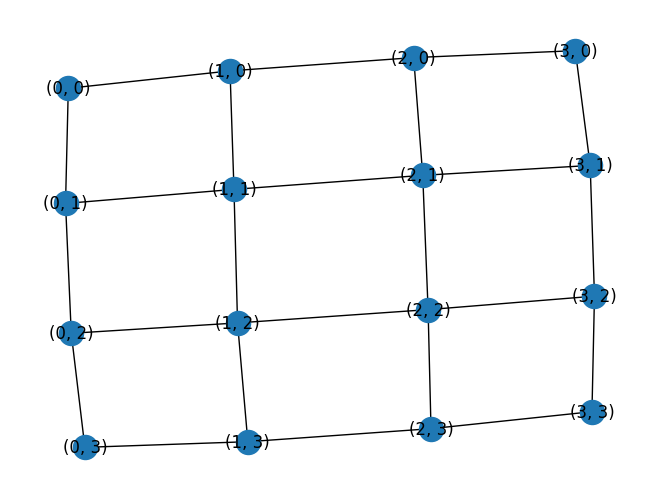

In [11]:
import networkx as nx
from networkx.algorithms.approximation import treewidth


G = nx.grid_2d_graph(4, 4)

nx.draw(G, with_labels=True)

width 4


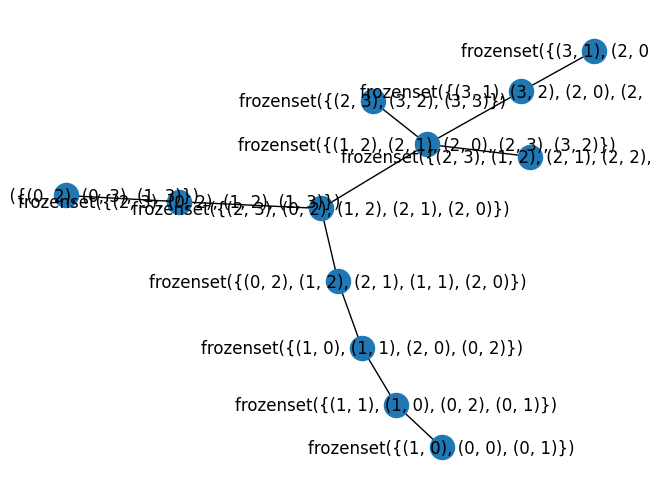

In [10]:
w, G1 = treewidth.treewidth_min_degree(G)
print("width", w)
nx.draw(G1, with_labels=True)

width 1


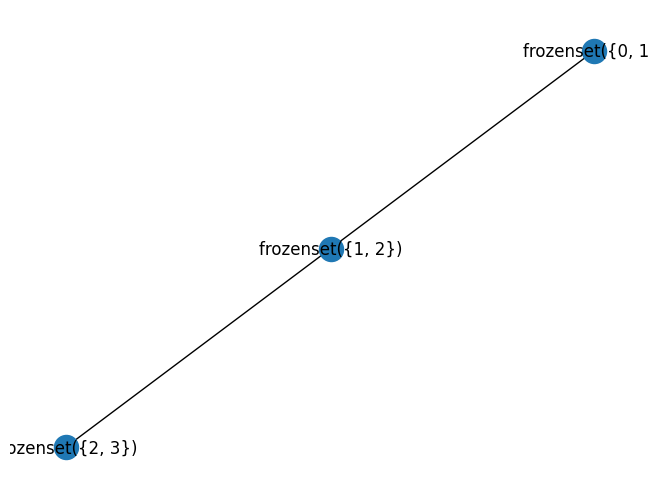

In [13]:
G = nx.path_graph(4)
#nx.draw(G, with_labels=True)
w, G1 = treewidth.treewidth_min_degree(G)
print("width", w)
nx.draw(G1, with_labels=True)

width 2


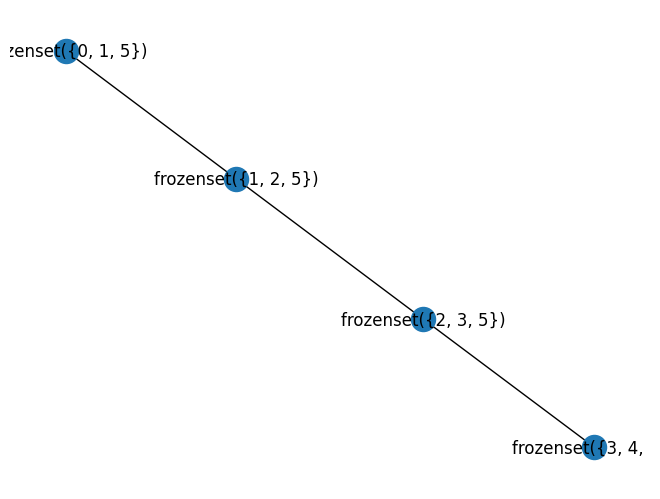

In [16]:
G = nx.cycle_graph(6)
#nx.draw(G, with_labels=True)
w, G1 = treewidth.treewidth_min_degree(G)
print("width", w)
nx.draw(G1, with_labels=True)

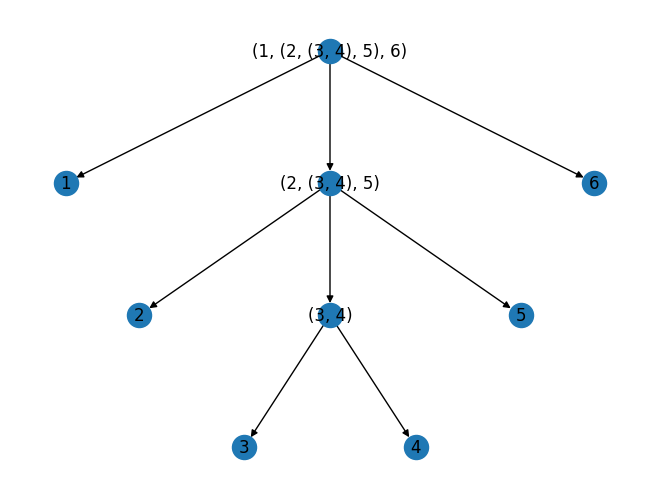

In [88]:
from typing import Iterable
def graph_of_tree(t):
    def worker(t):
        if isinstance(t, Iterable):
            G.add_edges_from([(t, c) for c in t])
            for c in t:
                worker(c)
    G = nx.DiGraph()
    worker(t)
    return G

G = graph_of_tree((1, (2, (3, 4), 5), 6))
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Requires pygraphviz
#pos = nx.planar_layout(G)
nx.draw(G, pos, with_labels=True)

def draw_tree(G):
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Requires pygraphviz
    nx.draw(G, pos, with_labels=True)



In [ ]:
from typing import NamedTuple
NT = NamedTuple
class Lam(NT): body: object
class App(NT): f: object; arg: object
class Var(NT): db: int

def graph_of_lam(t):
    G = nx.DiGraph()
    def worker(ctx, t):
        if isinstance(t, Lam):
            G.add_edge(ctx, t)
            worker(t, t.body)
        elif isinstance(t, App):
            G.add_edge(ctx, t)
            worker(t, t.f)
            worker(t, t.arg)
        elif isinstance(t, Var):
            G.add_edge( ctx[t.db])



width 1
TreeDecomp(nodes=frozenset({2, 3}),
           edges={(2, 3), (3, 2)},
           children=[TreeDecomp(nodes=frozenset({1, 2}),
                                edges={(1, 2), (2, 1)},
                                children=[TreeDecomp(nodes=frozenset({0, 1}),
                                                     edges={(0, 1), (1, 0)},
                                                     children=[])]),
                     TreeDecomp(nodes=frozenset({3, 4}),
                                edges={(3, 4), (4, 3)},
                                children=[])])


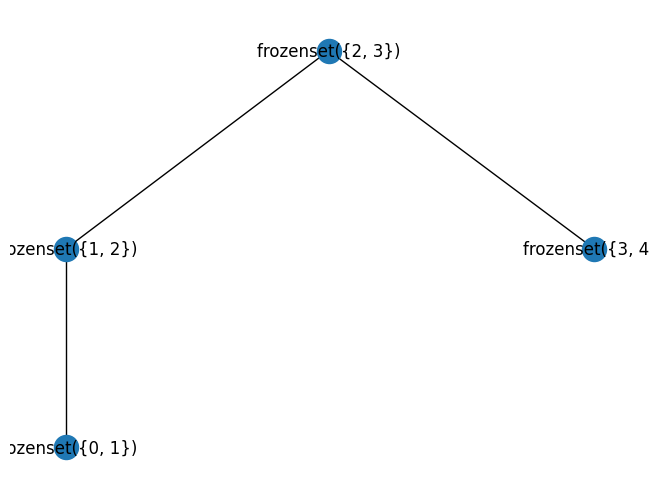

In [90]:
from dataclasses import dataclass

@dataclass
class TreeDecomp():
    nodes: set[object]
    edges : set[tuple[object, object]]
    children : list["TreeDecomp"]

    @classmethod
    def empty():
        return TreeDecomp(set(), set(), [])

    @classmethod
    def singleton(v):
        return TreeDecomp({v}, set(), [])
    
    @classmethod
    def from_tree(t):
        return TreeDecomp(t.nodes, t.edges, [TreeDecomp.from_tree(child) for child in t.children])
    
    def add_vertex(self,v): #?
        pass

    def contains(self, v):
        return v in self.nodes or any(child.contains(v) for child in self.children)

    def add_edge(self,v1,v2):
        """
        There is a distinction between adding an edge between already existing vertices and a new connecting vertex.

        Will add
        if v1 in self.nodes:
            self.nodes.add(v2)
        if v2 in self.nodes:
            self.nodes.add(v1)
        if v1 in nodes and v2 in nodes:
            edges.add((v1,v2))
        """
        if v1 in self.nodes and self.contains(v2):
            self.edges.add((v1,v2))
            self.nodes.add(v2)
        elif v2 in self.nodes and self.contains(v1):
            self.edges.add((v1,v2))
            self.nodes.add(v1)
        for child in self.children:
            child.add_edge(v1,v2)

    def rebalance(self):
        # rebuild :)
        # Or locally reabalnce. Up to depth N.
        # turn back to nx.Graph. Rebuild
        pass


class DecompForest():
    pieces : dict[TreeDecomp]
    vertmap : dict[object, TreeDecomp]
    def add_vertex(self, v):
        if v in self.vertmap:
            return self.vertmap[v]
        else:
            newtree == TreeDecomp.singleton(v)
            self.pieces[v] = self.vertmap[v]
            return self.vertmap[v]
    def add_edge(self, v1,v2):
        if v1 in vertmap:
            tree1 = vertmap[v1]
        elif v2 in vertmap:
            pass


def tree_decomp(G):
    w, G1 = treewidth.treewidth_min_degree(G)
    center_nodes = nx.center(G1)
    central_vertex = center_nodes[0]
    seen = set()
    def dfs(v):
        seen.add(v)
        children = [dfs(child) for child in G1.neighbors(v) if child not in seen]
        return TreeDecomp(nodes=v, edges=set((i,j) for i in v for j in v if (i,j) in G.edges), children=children)
    return dfs(central_vertex)

#nx.draw(nx.path_graph(3), with_labels=True)
w,G1 = treewidth.treewidth_min_degree(nx.path_graph(5))
print("width", w)
draw_tree(G1)
import pprint
pprint.pprint(tree_decomp(nx.path_graph(5)))

---
title: "Treeifying Graphs: A ubiquitous cheat"

---



Graham mentioned that "programming is fundamentally about trying to define coinductive things (behaviors) inductively (syntax trees)." Something to muse on

Make Tree decomposition.
Add hypereclass indirection

Needs interface to request a bundle of edges to be cut.

In [ ]:

# graph1 : V -> WeightedSet
def graph1(v): # aparasmeter is starting vertex
    yield from [(1, "a"), (2,"b")]
    # yeild weighted set, or generator of weighted set

def overlay(g1,g2):
    def res(v):

    return res
    pass

def connect(g1, g2):
    def res(v):
        pass
    return res

def star(g):
    pass

https://doisinkidney.com/posts/2024-11-08-formalising-graphs-coinduction.html
"There are a few ways to overcome these hurdles: in the functional programming world, huge
strides have been made by representing graphs as inductive data types [Erwig 2008; Gibbons 1995]
or with typeclasses [Mokhov 2017]. Specifically treating graphs as matrices has also proved useful,
especially in elucidating the link between semirings and search algorithms [Backhouse and Carré
1975; Conway 1971; Dolan 2013; Master 2021; Rivas et al. 2015]."
Graph V = V -> Neighbors V
Hmm niehgbors are weighted sets.
sem,iring
overlay and connection
 
Backhouse had a whole book of graph alogorithms right? https://www.academia.edu/39795690/Elements_of_Algorithmic_Graph_Theory_An_Exercise_in_Point_Free_Reasoning

Seem like kidney Wu 2021 is good prior reading https://doisinkidney.com/posts/2021-06-21-icfp-paper.html Algebras for Weighted Search



Graph homomorphisms are also acted on by the permutations of labels. left and right action. so... the slotted tensor thing maybe is like that? It's a graph homorphism from the symmetry graph of the slots to the labels...

Substitutions vs term homomorphisms

Catlab Csets. ALgerbaic rewriting DPO SPO.

https://doc.sagemath.org/html/en/reference/graphs/sage/graphs/graph_decompositions/rankwidth.html rank width decomposition rw
what's this all about?

https://doc.sagemath.org/html/en/reference/graphs/sage/graphs/graph_decompositions/modular_decomposition.html modular decomposition
https://doc.sagemath.org/html/en/reference/graphs/sage/graphs/graph_decompositions/tree_decomposition.html


What is a graph?

What do you want to do on it?


Search a graph
spanning tree
routing on a graph
shortest path
maximum flow
minimum cut
maximum matching
minimum spanning tree
strongly connected components
biconnected components
articulation points
bridges
2-edge connected components


colorings
covers

# Tree Decomposition

https://dl.acm.org/doi/10.1145/3689801  Fast and Optimal Extraction for Sparse Equality Graphs
https://github.com/mabseher/htd hypertree decomposition
https://github.com/PACE-challenge/Treewidth
https://pypi.org/project/treedecomp/
https://networkx.org/documentation/latest/reference/algorithms/approximation.html#module-networkx.algorithms.approximation.treewidth

https://en.wikipedia.org/wiki/Decomposition_method_(constraint_satisfaction)
https://en.wikipedia.org/wiki/Branch-decomposition

In [ ]:

for vs in powerset(vertices):



for p1,p2 in split(vs):
    hereedges = [(x,y) if x in p1 and y in y for x,y in edges]

# total splitting of vertices is not necessary though

BoolRef(bag) for bag in powerset(vs)
BoolRef() for bagedges
# union of all aselected bags in all vertices
# one of bags containing egde must be selected



In [ ]:
# brute force
graph = [(1,2),(3,4), (4,5)]

# https://docs.python.org/3/library/itertools.html#itertools-recipes
def powerset(iterable):
    "powerset([1,2,3]) → () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def all_tree_decomp(V,G):
    #vertices = list(set(i for i,j in G) + set(j for i,j in G))
    # pick some for this bag
    # pick some edges
    if len(V) == 0:
        return () 
    for deledges in powerset(G):
        bag = set([i for i,j in deledges] + [j for i,j in deledges])
        # one or more children
        # all ways of breaking up? multinomial?
        # two overlapping subsets?
        # Well ok, binary tree decompositions is possibly a different thing, but why not



    for bag in powerset(V):
        # how do I make progress?
        # check if this bag is a separator
        is_separator = True
        for i,j in G:
            if i in bag and j in bag:
                is_separator = False
                break
        if is_separator:
            # if it is a separator, then split the graph
            #G1 = [(i,j) for i,j in G if i in bag or j in bag]
            needed = [(i,j) for i,j in G if i not in bag and j not in bag]
            # recursively call the function
            for T1 in all_tree_decomp(G1):
                for T2 in all_tree_decomp(G2):
                    yield (bag, T1, T2)
            break

def all_tree(active_edge, bag, G):
    

# each bag will only appear once right?

# eaiser to do bottom up maybe?

for bag in powerset(V):
    active = set( i,j for i,j in G if i in bag j not in bag)
    dealt_with = set( i,j for i,j in G if i in bag and j in bag)
    todo = [(active, dealt_with, bag)]
passive = []
while todo:
    active, dealt_with, bag = todo.pop()
    for d in passive: # search for other passive sibling bags
        


    passive.append((active, dealt_with, bag))


todo = [(set(range(1,6)), graph)]
while todo:
    active, bag = todo.pop()
    for newverts in powerset(V - bag) # but has to contain active + 1
        for usedactive in powerset(active):
            if len(usedactive) == 0:
                continue
            else:
                newbag = usedactive | newverts
                
                todo.append((newverts, newbag, newgraph))

for bag in powerset(V):


def is_tree_decmp(d, G):



In [ ]:
# tree decomp
class Node():
    bag: set[V]
    bagedges : set[E]
    children: set[Node]

    def treewidth(self):
        return max(len(self.bag) - 1, max([c.treewidth() for c in self.children]))
    

class GraphTree():
    here: set[V] # nodes only here
    edges: set[E] #egdes between only here and children
    children: set[tuple[set[V], GraphTree]]

    def color(self, colors):
       # take in a list of colors 


In [ ]:
V = int
Edge = tuple[V,V]

# flat reps
Graph1 = set[Edge]
Graph2 = list[Edge]
Graph3 = dict[V, set[V]]


# structured representations

In [ ]:
# kerngihan Lin

def kl(edges):
    A = set()
    B = set()
    



# Graph canonicalization

## group theory
This is neither here nor there kind of. It's "just" for symmettry breaking during search, which is especially painful in canonization search


caonicalizing graphs  via brute force. Come up with a system of serialzing, sort those strings. Not necessarily stable in any sense though
graph isomorphism
Sims-schreiers

schreir vectors = spanning tree. (?) store group element that would connect to previous node of spanning tree. 
This is the group union find? Huh.

schreir sims - a canonical form of group element. https://en.wikipedia.org/wiki/Schreier%E2%80%93Sims_algorithm

Stabilizer = subgroup defined as the the group elements that leave a particular elemement unchanged

Schreir generators. If we pick representatives of the cosets of a subgroup, we can generate the subgroup using combined generators and repsdentatives as generators.

Return stabilizer of initial point as collection of schreier generatoras. Orbit stabilizer algorithm

https://en.wikipedia.org/wiki/Group_action

undirected Graph where every neighborhood has the same moves = group action on vertex set. edge pattern is generators. 
https://en.wikipedia.org/wiki/Cayley_graph
Origin is special or no?
Stabilizer group of origin are loops.
rubiks cube

https://terrytao.wordpress.com/2010/07/10/cayley-graphs-and-the-geometry-of-groups/
subgroups and bundles

a base, special points.
What if graph is disconnected?

Consider general graphs as mangled cayley graphs.
Even if I was given two cayley graphs is it obvious how to canonicaslize it?
The point of gropup theory is to cut down on boring symmettry explosion. Where is this?

cosets partition... partition refinement using group tags?

g = (h, g')  where h is element of subgroup and g' is caonoical represdentiatvie of coset


In [14]:
from dataclasses import dataclass
@dataclass(frozen=True)
class Perm():
    perm : list[int]
    @classmethod  
    def e(self, n):
        return Perm(list(range(n)))
    def __mul__(self, other):
        return Perm([self.perm[p] for p in other.perm])
    
e3 = Perm.e(3)
assert e3 * e3 == e3
p = Perm([1,0])
assert p * p == Perm.e(2)
assert Perm([1,2,0]) * Perm([2,0,1]) == Perm([0,1,2])


def naive()


Suppose I wanted the automorphism group.
Can I generate it?

 swaps
Generate permutation group. swaps

Also, swaps are kind of an incrementalo strcturue which is good for functional programming maybe.

note that this is a method to generate permutations too. swap to decide which element of remaining in in nth position.

https://en.wikipedia.org/wiki/Steinhaus%E2%80%93Johnson%E2%80%93Trotter_algorithm  Steinhaus–Johnson–Trotter algorithm
https://en.wikipedia.org/wiki/Heap%27s_algorithm
https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle randomly genrate a permutation

In [ ]:


def canon(G, N):
    swaps = [(i,j) for i in range(N) for j in range(i)]
    for 
    for p in permutations(range(3)):
        yield perm_graph(p, G)

If we do a more careful backtracking search, we can prune a lot.
We learn partial order constraints as we go. Maybe a difference logic thing would be helpful.
We get good strings by ordering the vertices by degree first.
We can do a lot of propagation.
We can do prefix comparison because we're being lexicographic.





We could have other representations of graphs. A tree representation follows naturally from Tree Decomposition (kind of. We also need to create a unique tree decomp... or use an ordering that doesn't care which tree decomp we picked. Hmmmm. best Spanning tree? Again tie breaking here brings in graph canonization. These things need to be considered bolted together).
We could then use total tree orderings instead of string orderings.

"Natrual graph orderings" like that minor homomorphism thing. https://en.wikipedia.org/wiki/Robertson%E2%80%93Seymour_theorem

Maybe this is more sensical for tree with backref ids. Which numbers do we put in the backref ids to make canonical. Then the tree structure exists a priori.


In [22]:
# to get cycles. Orbits under subgroup consisting of p^n. Generated by <p>
def cycles(p):
    found = set()
    for i in range(len(p)):
        if i not in found:
            cycle = []
            j = i
            while j not in cycle:
                cycle.append(j)
                j = p[j]
            yield cycle
            found.update(cycle)

list(cycles([1,0,2]))

def inv(p):
    inv = [0]*len(p)
    for i in range(len(p)):
        inv[p[i]] = i
    return inv

def orbit(ps, n):
    found = set()
    done = False
    while not done:
        done = False
        for f in found:
            for p in ps:
                e = p[f]
                if e not in found:
                    done = False
                    found.add(e)

Perm = list[int]
# orbit of is fixed point of this operation starting from {x}.
def step(G : list[Perm], s : set[int]) -> set[int]: # G is list/set of permutations
    return s | {p[i] for p in G for i in s}

def is_inv(G,s):
    return s == step(G,s)

# can apply standard seminaive trick
# can retain "proof" / path as group union find.

# schreier vectors


# base
# strong generating set



[[0, 1], [2]]

In [ ]:
def termact(p, t):
    head,*args = t
    return (head,*[termact(p,a) for a in args])
def canon(t, N):
    # a silly implementation.
    min([ termact(p,t) for p in itertools.permutations(range(N))])



In [ ]:

import metis

import networkx as nx
G = nx.path_graph(7)
edgecuts, parts = metis.part_graph(G,3)
print(edgecuts, parts)

print(nx.community.kernighan_lin_bisection(G)) # anneal a cut by node swapping
print(list(nx.community.girvan_newman(G))) # remove edges from graph

In [22]:

import sqlite3
import networkx as nx
def db_of_graph(conn, G):
    con.executemany("INSERT INTO nodes VALUES (?)", map(lambda v : (v,),  G.nodes))
    con.executemany("INSERT INTO edges VALUES (?, ?)", G.edges)
    if not G.is_directed():
        con.executemany("INSERT INTO edges VALUES (?, ?)", [(j,i) for i,j in G.edges])
def graph_of_db(con):
    G = nx.DiGraph()
    res = con.execute("SELECT * FROM nodes")
    G.add_nodes_from(map(lambda x: x[0], res.fetchall()))
    res = con.execute("SELECT * FROM edges")
    G.add_edges_from(res.fetchall())
    return G
def query_of_graph(G,unique=False):
    """Unique will give subgraph isomorphism"""
    selects = []
    froms = []
    wheres = []
    for node in G:
        froms += [f"nodes AS v{node}"]
        selects += [f"v{node}.v AS v{node}"]
    for i, (a,b) in enumerate(G.edges):
        froms += [f"edges as e{i}"]
        wheres += [f"e{i}.src = v{a}.v"  , f"e{i}.dst = v{b}.v"]
    if unique:
        for node in G:
            for node2 in G:
                if node != node2:
                    wheres += [f"v{node} != v{node2}"]
    sql = "SELECT " + ", ".join(selects) + \
          "\nFROM " +  ", ".join(froms) + \
          "\nWHERE " + " AND ".join(wheres)
    return sql
def clear_db(con):
    con.execute("DELETE FROM nodes")
    con.execute("DELETE FROM edges")
G = nx.path_graph(7, create_using=nx.DiGraph)
lhs = nx.path_graph(3, create_using=nx.DiGraph)
con = sqlite3.connect(":memory:")

con.execute("CREATE TABLE nodes(v)")
con.execute("CREATE TABLE edges(src,dst)")
db_of_graph(con, G)
res = con.execute(query_of_graph(lhs))
print(res.fetchall())
# Result: [(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6)]



[(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6)]


In [13]:
res = con.execute(query_of_graph(G))
print(query_of_graph(G))
res.fetchall()

SELECT v0.v AS v0, v1.v AS v1, v2.v AS v2, v3.v AS v3, v4.v AS v4, v5.v AS v5, v6.v AS v6
FROM nodes AS v0, nodes AS v1, nodes AS v2, nodes AS v3, nodes AS v4, nodes AS v5, nodes AS v6, edges as e0, edges as e1, edges as e2, edges as e3, edges as e4, edges as e5
WHERE e0.src = v0.v AND e0.dst = v1.v AND e1.src = v1.v AND e1.dst = v2.v AND e2.src = v2.v AND e2.dst = v3.v AND e3.src = v3.v AND e3.dst = v4.v AND e4.src = v4.v AND e4.dst = v5.v AND e5.src = v5.v AND e5.dst = v6.v


[(0, 1, 2, 3, 4, 5, 6)]

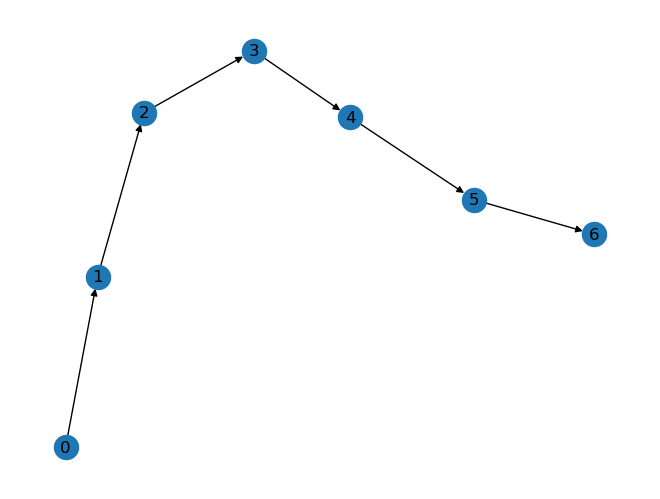

In [11]:
nx.draw(G, with_labels=True)

In [26]:
clear_db(con)
G = nx.path_graph(4)
db_of_graph(con, G)
res = con.execute(query_of_graph(G))
res.fetchall()
# undirected graph


[(1, 0, 1, 0),
 (1, 0, 1, 2),
 (0, 1, 0, 1),
 (0, 1, 2, 1),
 (0, 1, 2, 3),
 (2, 1, 0, 1),
 (2, 1, 2, 1),
 (2, 1, 2, 3),
 (1, 2, 1, 0),
 (1, 2, 1, 2),
 (1, 2, 3, 2),
 (3, 2, 1, 0),
 (3, 2, 1, 2),
 (3, 2, 3, 2),
 (2, 3, 2, 1),
 (2, 3, 2, 3)]

The two isomorphisms of the path graph

In [27]:
res = con.execute(query_of_graph(G,unique=True))
res.fetchall()

[(0, 1, 2, 3), (3, 2, 1, 0)]

Here we find a mapping into a color table considered as a complete graph
The lack of self edges in the color graph means no 

In [28]:
print(graph_of_db(con))
"DELETE FROM nodes WHERE nodes.v = ?"
"DELETE FROM edges where edges.src = ? OR edges.dst = ?"

clear_db(con)
colors = nx.complete_graph(2) # a two coloring
db_of_graph(con,colors)
# symmetrize. Maybe db_of_graph should do this. if not isinstanc(G,nx.DiGraph)
#con.execute("INSERT INTO edges SELECT edges.dst, edges.src FROM edges")
res = con.execute("SELECT * FROM edges")
res = print(res.fetchall())
res = con.execute(query_of_graph(G)) # two dimer colorings
print(res.fetchall())
# [(1, 0, 1, 0, 1, 0, 1), (0, 1, 0, 1, 0, 1, 0)]


DiGraph with 4 nodes and 6 edges
[(0, 1), (1, 0)]
[(1, 0, 1, 0), (0, 1, 0, 1)]
